# Load Dataset


In [1]:
from datasets import load_dataset

filename = "../data/news-docs.2020.processed.csv"
dataset = load_dataset('csv', data_files=filename, column_names=["date", "sentenceSplit", "unsplit"])

Using custom data configuration default-a631fcd5c80eb05a
Reusing dataset csv (/home/sri/.cache/huggingface/datasets/csv/default-a631fcd5c80eb05a/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


In [3]:
dataset['train'].shape

(1606655, 4)

# Load model

In [1]:
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

In [2]:
from src.lm_core import GPTLM

gpt = GPTLM()

In [4]:
raw_text = dataset['train'][1]['sentenceSplit']
article_list = raw_text.split("\n")

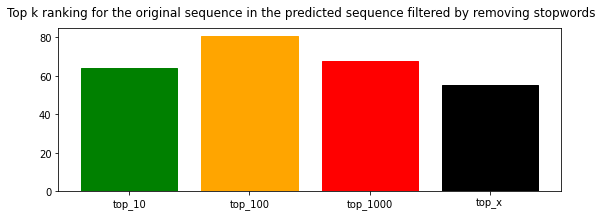

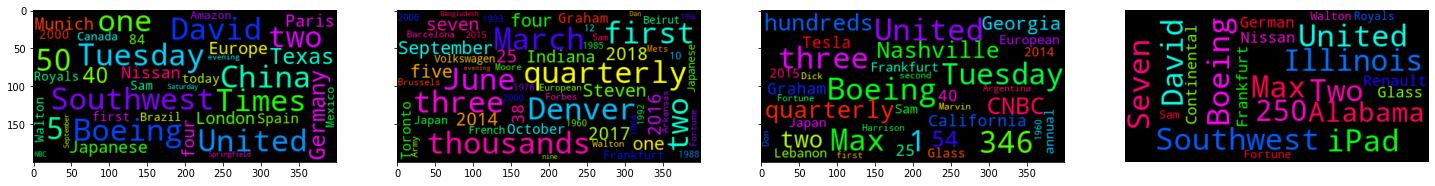

In [71]:
#analyse_text([article[i]['sentenceSplit'] for i in dataset['train'].shape[0]])
#analyse_text([dataset['train'][i]['sentenceSplit'] for i in range(5)])

from src.insights import topk_insight

topk_insight.analyse_text([dataset['train'][i]['sentenceSplit'] for i in range(5)])

In [27]:
import numpy as np

def analyse_text(articles: List, filters=None, probs_plot=False, starting_idx=0 ,
                 path="data/"):
    # from nltk.corpus import stopwords

    ################
    # import nltk
    # nltk.download('stopwords')
    ###############

    # curated stop_words
    if filters=="stopwords":
        with open("stopwords-en.txt") as f:
            content = f.readlines()
        stop_words = set([x.strip() for x in content] + list(string.punctuation))

    top_10_cnt, word_dict_10, probs_10 = 0, {}, []
    top_100_cnt, word_dict_100, probs_100 = 0, {}, []
    top_1000_cnt, word_dict_1000, probs_1000 = 0, {}, []
    top_x_cnt, word_dict_x, probs_x = 0, {}, []

    for article in articles:
        article_list = article.split("\n\n")

        # sen = ""
        # for s in article_list:
        #     if len((s + sen).split(' ')) < 800:
        #         sen = sen + " " + s
        # article = sen[1:]

        if filters=="ents":
            doc = nlp(article)
            ent_list = [ent.text for ent in doc.ents]

            np_list = [str(token) for token in doc if token.tag_[:2] == "NN"]

        for sentence in article_list:
        #for sentence in [article]:
            if len(sentence.split(" ")) > 5:
                text = gpt.tokenizer.bos_token + " " + sentence
                outputs = gpt.get_probabilities(text, top_k=1000)
                for idx, (rank, probs) in enumerate(outputs['true_topk'][starting_idx:]):
                    flag = True
                    if filters=="ents" and (outputs['bpe_strings'][idx + 1] not in ent_list): # or outputs['bpe_strings'][idx + 1] not in np_list):
                        flag = False
                    elif filters=="stopwords" and outputs['bpe_strings'][idx + 1] in stop_words:
                        flag = False

                    if flag:
                        if rank <= 10:
                            top_10_cnt += 1
                            word_dict_10[outputs['bpe_strings'][idx + 1]] = probs
                            # TODO: can include wordcloud for this too.
                            #probs_10.append(np.log(outputs['pred_topk'][idx][0][1]))
                            probs_10.append(outputs['pred_topk'][idx][0][1])
                        elif rank <= 100:
                            top_100_cnt += 1
                            word_dict_100[outputs['bpe_strings'][idx + 1]] = probs
                            #probs_100.append(np.log(outputs['pred_topk'][idx][0][1]))
                            probs_100.append(outputs['pred_topk'][idx][0][1])
                        elif rank <= 1000:
                            top_1000_cnt += 1
                            word_dict_1000[outputs['bpe_strings'][idx + 1]] = probs
                            #probs_1000.append(np.log(outputs['pred_topk'][idx][0][1]))
                            probs_1000.append(outputs['pred_topk'][idx][0][1])
                        elif rank>1000:
                            top_x_cnt += 1
                            word_dict_x[outputs['bpe_strings'][idx + 1]] = probs
                            #probs_x.append(np.log(outputs['pred_topk'][idx][0][1]))
                            probs_x.append(outputs['pred_topk'][idx][0][1])

    data = {'top_10': top_10_cnt, 'top_100': top_100_cnt, 'top_1000': top_1000_cnt, 'top_x': top_x_cnt}
    scatter_plot(probs_x)
    return outputs

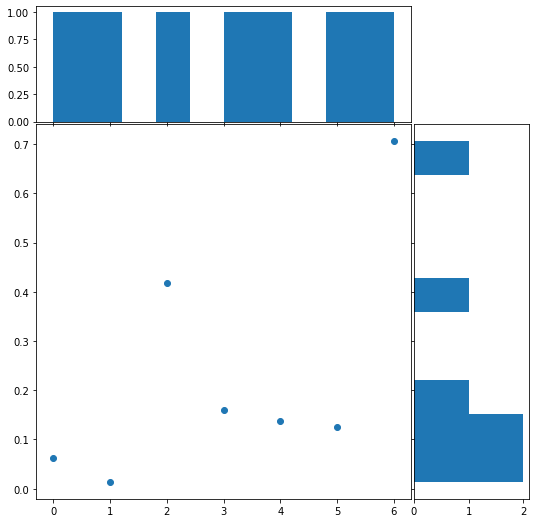

In [28]:
#text = "Sorry, I’m not sure what you mean by a button that waits to be clicked. How would you like the following toy example to be improved ? assume load_data is a file_uploader instead and the transformation of the user selected columns to categorical is made in the train_model"

outputs = analyse_text([arxiv])

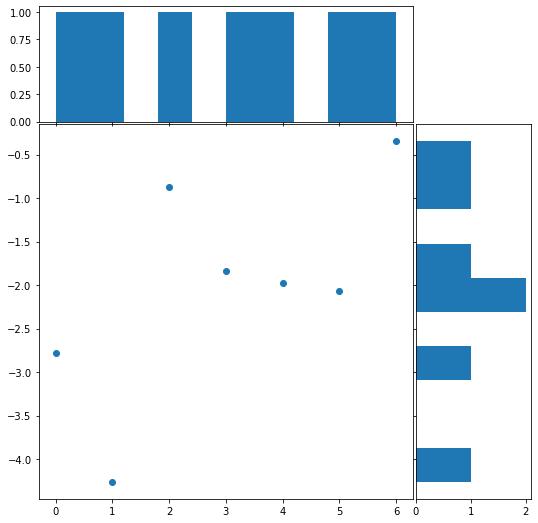

In [26]:
#text = "Sorry, I’m not sure what you mean by a button that waits to be clicked. How would you like the following toy example to be improved ? assume load_data is a file_uploader instead and the transformation of the user selected columns to categorical is made in the train_model"

outputs = analyse_text([arxiv])

In [8]:
outputs['bpe_strings']

['<|endoftext|>',
 'Sorry',
 ',',
 'I',
 ' ',
 "'",
 'm',
 'not',
 'sure',
 'what',
 'you',
 'mean',
 'by',
 'a',
 'button',
 'that',
 'waits',
 'to',
 'be',
 'clicked',
 '.',
 'How',
 'would',
 'you',
 'like',
 'the',
 'following',
 'toy',
 'example',
 'to',
 'be',
 'improved',
 '?',
 'assume',
 'load',
 '_',
 'data',
 'is',
 'a',
 'file',
 '_',
 'upload',
 'er',
 'instead',
 'and',
 'the',
 'transformation',
 'of',
 'the',
 'user',
 'selected',
 'columns',
 'to',
 'categ',
 'orical',
 'is',
 'made',
 'in',
 'the',
 'train',
 '_',
 'model']

In [12]:
outputs['pred_topk']

[[(' ', 0.0623),
  ('The', 0.0377),
  ('"', 0.02411),
  ('A', 0.0194),
  ('I', 0.01832),
  ('In', 0.01158),
  ('.', 0.0113),
  ('It', 0.00912),
  ('S', 0.00866),
  ('This', 0.00777),
  ('B', 0.00769),
  ('-', 0.00765),
  ('C', 0.00719),
  ('We', 0.00701),
  ('1', 0.00671),
  ('T', 0.00665),
  ("'", 0.006),
  ('P', 0.00575),
  ('(', 0.00575),
  ('G', 0.00551),
  ('D', 0.00523),
  ('H', 0.00511),
  ('M', 0.00493),
  ('You', 0.00487),
  ('F', 0.00483),
  ('K', 0.00467),
  ('If', 0.00462),
  ('2', 0.00462),
  (':', 0.00428),
  ('R', 0.00427),
  ('L', 0.00407),
  ('U', 0.00395),
  ('For', 0.00391),
  ('There', 0.00385),
  ('N', 0.00381),
  ('E', 0.00364),
  ('As', 0.00357),
  ('W', 0.00352),
  (',', 0.00348),
  ('J', 0.00338),
  ('What', 0.00334),
  ('To', 0.00333),
  ('[', 0.00318),
  ('3', 0.00317),
  ('When', 0.00305),
  ('On', 0.00297),
  ('V', 0.00295),
  ('4', 0.0029),
  ('/', 0.00287),
  ('One', 0.00279),
  ('By', 0.00277),
  ('He', 0.00261),
  ('0', 0.00245),
  ('But', 0.00238),
  (

In [11]:
len(outputs['bpe_strings']), len(outputs['true_topk']), len(outputs['pred_topk'])

(62, 61, 61)

In [5]:
top_10_cnt = 0
top_100_cnt = 0
top_1000_cnt = 0
top_x_cnt = 0

for sentence in article_list:
    text = gpt.tokenizer.bos_token + " " + sentence
    outputs = gpt.get_probabilities(text, top_k=1000)
    for rank, probs in outputs['true_topk']:
        if rank<=10:
            top_10_cnt += 1
        elif rank<=100:
            top_100_cnt += 1
        elif rank<=1000:
            top_1000_cnt += 1
        else:
            top_x_cnt += 1

In [13]:
import numpy as np
#np.sum(outputs['pred_topk'][0], axis=1)
np.sum([prob for tok, prob in outputs['pred_topk'][0]])

0.75268

In [25]:
print (top_10_cnt, top_100_cnt, top_1000_cnt, top_x_cnt)

680 198 130 80


Text(0.5, 0.98, 'Top k ranking for the original sequence in the predicted sequence filtered by removing stopwords')

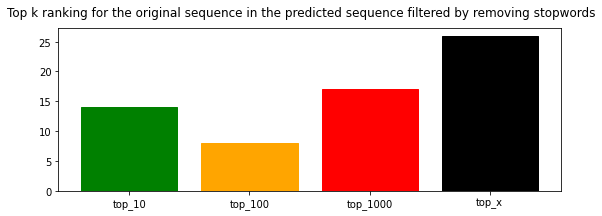

In [49]:
import matplotlib.pyplot as plt

data = {'top_10': top_10_cnt, 'top_100': top_100_cnt, 'top_1000': top_1000_cnt, 'top_x': top_x_cnt}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 1, figsize=(9, 3), sharey=True)
bar = axs.bar(names, values)
bar[0].set_color('green')
bar[1].set_color('orange')
bar[2].set_color('red')
bar[3].set_color('black')
fig.suptitle('Top k ranking for the original sequence in the predicted sequence filtered by removing stopwords')

In [31]:
#from nltk.corpus import stopwords

################
#import nltk
#nltk.download('stopwords')
###############

# curated stop_words
import string

with open("../data/stopwords-en.txt") as f:
    content = f.readlines()
stop_words = set([x.strip() for x in content] + list(string.punctuation)) 


top_10_cnt = 0
top_100_cnt = 0
top_1000_cnt = 0
top_x_cnt = 0

word_dict_10 = {}
word_dict_100 = {}
word_dict_1000 = {}
word_dict_x = {}

for sentence in article_list:
    if len(sentence.split(" "))>5:
        text = gpt.tokenizer.bos_token + " " + sentence
        outputs = gpt.get_probabilities(text, top_k=1000)
        for idx, (rank, probs) in enumerate(outputs['true_topk']):
            if outputs['bpe_strings'][idx+1] not in stop_words:
                #print(outputs['bpe_strings'][idx+1])
                if rank<=10:
                    top_10_cnt += 1
                    word_dict_10[outputs['bpe_strings'][idx+1]] = 100
                    #print(outputs['bpe_strings'][idx+1], outputs['pred_topk'][idx][rank])
                elif rank<=100:
                    top_100_cnt += 1
                    word_dict_100[outputs['bpe_strings'][idx+1]] = 100
                elif rank<=1000:
                    top_1000_cnt += 1
                    word_dict_1000[outputs['bpe_strings'][idx+1]] = 100
                else:
                    top_x_cnt += 1
                    word_dict_x[outputs['bpe_strings'][idx+1]] = 100

Text(0.5, 0.98, 'Top k ranking for the original sequence in the predicted sequence filtered by removing stopwords')

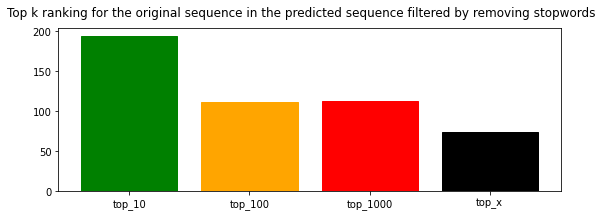

In [26]:
import matplotlib.pyplot as plt

data = {'top_10': top_10_cnt, 'top_100': top_100_cnt, 'top_1000': top_1000_cnt, 'top_x': top_x_cnt}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 1, figsize=(9, 3), sharey=True)
bar = axs.bar(names, values)
bar[0].set_color('green')
bar[1].set_color('orange')
bar[2].set_color('red')
bar[3].set_color('black')
fig.suptitle('Top k ranking for the original sequence in the predicted sequence filtered by removing stopwords')

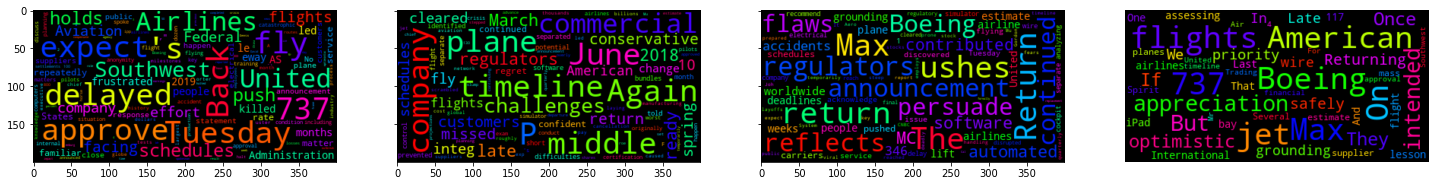

In [44]:
from wordcloud import WordCloud

cloud10 = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_10)
cloud100 = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_100)
cloud1000 = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_1000)
cloudx = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_x)
fig, axs = plt.subplots(1, 4, figsize=(25,20), sharey=True)
#plt.figure(figsize=(16,12))
axs[0].imshow(cloud10, interpolation='bilinear')
axs[1].imshow(cloud100, interpolation='bilinear')
axs[2].imshow(cloud1000, interpolation='bilinear')
axs[3].imshow(cloudx, interpolation='bilinear')

plt.axis('off')
plt.show()

In [7]:
from src.insights import topk_insight
#from nltk.corpus import stopwords

################
#import nltk
#nltk.download('stopwords')
###############

# curated stop_words
import spacy

nlp = spacy.load("en_core_web_sm")


top_10_cnt = 0
top_100_cnt = 0
top_1000_cnt = 0
top_x_cnt = 0

word_dict_10 = {}
word_dict_100 = {}
word_dict_1000 = {}
word_dict_x = {}

doc = nlp(raw_text)
ent_list = [ent.text for ent in doc.ents]

#for sentence in article_list:
for sentence in [raw_text]:
    sen = ""
    for s in sentence.split(' '):
        if len((s + sen).split(' '))<800:
            sen = sen + " " + s
    sentence = sen[1:]
    if len(sentence.split(" "))>5:
        text = gpt.tokenizer.bos_token + " " + sentence
        outputs = gpt.get_probabilities(text, top_k=1000)
        for idx, (rank, probs) in enumerate(outputs['true_topk']):
            if outputs['bpe_strings'][idx+1] in ent_list:
                #print(outputs['bpe_strings'][idx+1])
                if rank<=10:
                    top_10_cnt += 1
                    word_dict_10[outputs['bpe_strings'][idx+1]] = 100
                    #print(outputs['bpe_strings'][idx+1], outputs['pred_topk'][idx][rank])
                elif rank<=100:
                    top_100_cnt += 1
                    word_dict_100[outputs['bpe_strings'][idx+1]] = 100
                elif rank<=1000:
                    top_1000_cnt += 1
                    word_dict_1000[outputs['bpe_strings'][idx+1]] = 100
                else:
                    top_x_cnt += 1
                    word_dict_x[outputs['bpe_strings'][idx+1]] = 100

Text(0.5, 0.98, 'Top k ranking for the original sequence in the predicted sequence filtered by removing stopwords')

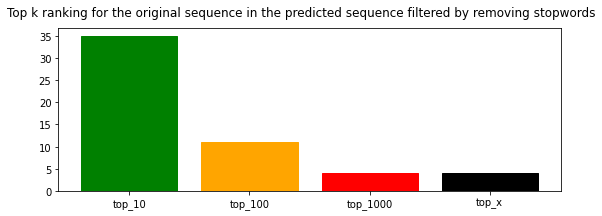

In [8]:
import matplotlib.pyplot as plt

data = {'top_10': top_10_cnt, 'top_100': top_100_cnt, 'top_1000': top_1000_cnt, 'top_x': top_x_cnt}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 1, figsize=(9, 3), sharey=True)
bar = axs.bar(names, values)
bar[0].set_color('green')
bar[1].set_color('orange')
bar[2].set_color('red')
bar[3].set_color('black')
fig.suptitle('Top k ranking for the original sequence in the predicted sequence filtered by removing stopwords')

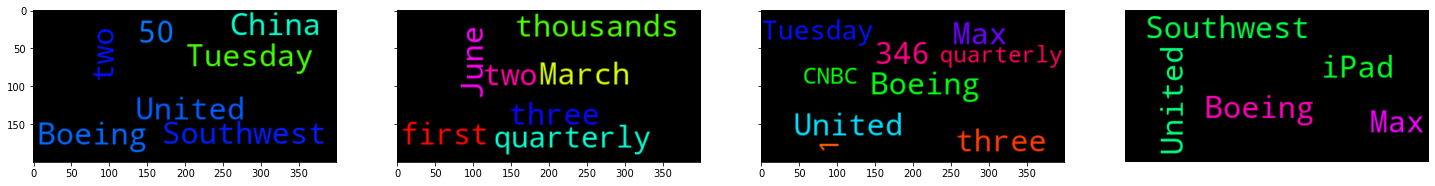

In [65]:
from wordcloud import WordCloud

cloud10 = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_10)
cloud100 = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_100)
cloud1000 = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_1000)
cloudx = WordCloud(max_font_size=40,colormap="hsv").generate_from_frequencies(word_dict_x)
fig, axs = plt.subplots(1, 4, figsize=(25,20), sharey=True)
#plt.figure(figsize=(16,12))
axs[0].imshow(cloud10, interpolation='bilinear')
axs[1].imshow(cloud100, interpolation='bilinear')
axs[2].imshow(cloud1000, interpolation='bilinear')
axs[3].imshow(cloudx, interpolation='bilinear')

plt.axis('off')
plt.show()

In [76]:
print(len(outputs['pred_topk']), len(outputs['true_topk']))

22 22


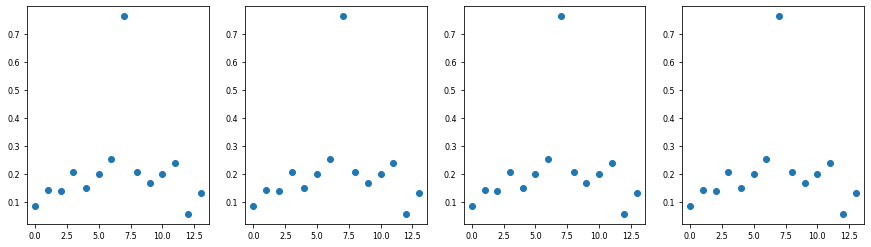

In [164]:
import numpy as np
import matplotlib.pyplot as plt

def scatter_plot(probs):
    x = list(range(len(probs)))
    y = probs
    
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    # start with a square Figure
    #fig = plt.figure(figsize=(4, 4))
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    
    #ax = fig.add_axes(rect_scatter)
    #ax_histx = fig.add_axes(rect_histx, sharex=ax)
    #ax_histy = fig.add_axes(rect_histy, sharey=ax)

    #ax_histx.tick_params(axis="x", labelbottom=False)
    #ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    axs[0].scatter(x, y)
    axs[1].scatter(x, y)
    axs[2].scatter(x, y)
    axs[3].scatter(x, y)

    #ax_histx.hist(x)
    #ax_histy.hist(y, orientation='horizontal')
    

    plt.show()
    
scatter_plot(probs_10)

In [126]:
#from nltk.corpus import stopwords

################
#import nltk
#nltk.download('stopwords')
###############

# curated stop_words
import spacy

nlp = spacy.load("en_core_web_sm")

top_10_cnt, word_dict_10, probs_10 = 0, {}, []
top_100_cnt, word_dict_100, probs_100 = 0, {}, []
top_1000_cnt, word_dict_1000, probs_1000 = 0, {}, []
top_x_cnt, word_dict_x, probs_x = 0, {}, []

doc = nlp(raw_text)
ent_list = [ent.text for ent in doc.ents]

for sentence in article_list:
    if len(sentence.split(" "))>5:
        text = gpt.tokenizer.bos_token + " " + sentence
        outputs = gpt.get_probabilities(text, top_k=1000)
        for idx, (rank, probs) in enumerate(outputs['true_topk']):
            if outputs['bpe_strings'][idx+1] in ent_list:
                #print(outputs['bpe_strings'][idx+1], outputs['pred_topk'][idx][0][1])
                if rank<=10:
                    top_10_cnt += 1
                    word_dict_10[outputs['bpe_strings'][idx+1]] = 100
                    probs_10.append(outputs['pred_topk'][idx][0][1])
                    #print(outputs['bpe_strings'][idx+1], outputs['pred_topk'][idx][rank])
                elif rank<=100:
                    top_100_cnt += 1
                    word_dict_100[outputs['bpe_strings'][idx+1]] = 100
                    probs_100.append(outputs['pred_topk'][idx][0][1])
                elif rank<=1000:
                    top_1000_cnt += 1
                    word_dict_1000[outputs['bpe_strings'][idx+1]] = 100
                    probs_1000.append(outputs['pred_topk'][idx][0][1])
                else:
                    top_x_cnt += 1
                    word_dict_x[outputs['bpe_strings'][idx+1]] = 100
                    #print(outputs['true_topk'][idx])
                    probs_x.append(outputs['pred_topk'][idx][0][1])

In [127]:
probs_x

[0.0623,
 0.17308,
 0.11608,
 0.12457,
 0.0623,
 0.03981,
 0.04728,
 0.10446,
 0.27672,
 0.01043,
 0.19621,
 0.0623,
 0.04586,
 0.15203,
 0.0623,
 0.06895,
 0.01473,
 0.19018,
 0.0623,
 0.0623,
 0.08857,
 0.0623,
 0.24742,
 0.33101,
 0.0623,
 0.03454]

In [170]:
str([token for token in doc if token.tag_[:2]=="NN"][0])

'Boeing'

In [18]:
import matplotlib.pyplot as plt
def scatter_plot(probs_10):
    x, y = list(range(len(probs_10))), probs_10
    #x10, y10 = list(range(len(probs_10))), probs_10
    #x100, y100 = list(range(len(probs_100))), probs_100
    #x1000, y1000 = list(range(len(probs_1000))), probs_1000
    #xx, yx = list(range(len(probs_x))), probs_x


    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    # start with a square Figure
    fig = plt.figure(figsize=(8, 8))
    #fig, axs = plt.subplots(1, 4, figsize=(15, 4))

    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)

    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)
    #axs[0].scatter(x10, y10)
    #axs[1].scatter(x100, y100)
    #axs[2].scatter(x1000, y1000)
    #axs[3].scatter(xx, yx)

    ax_histx.hist(x)
    ax_histy.hist(y, orientation='horizontal')

    plt.show()
    #with col:
        # st.header("")
    #    st.pyplot(fig)
    #plt.savefig(path)
    #st.image("data/scatter.jpg")

In [20]:
arxiv = """
The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data.
"""